# Import Dependencies and create functions

In [4]:
import os
import catboost

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, mean_squared_error, silhouette_score, adjusted_rand_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans

import scipy.cluster.hierarchy as sch
from catboost import CatBoostClassifier

In [82]:
def max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        ct = DecisionTreeClassifier(max_leaf_nodes = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, ct.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, ct.predict(X_test)))
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")

    
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestClassifier(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    
def rf_max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestClassifier(n_estimators=5, max_leaf_nodes =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")

def catboost_best_iterations(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostClassifier(iterations=i,random_state=10).fit(X_train, y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel('"MSE')
    ax.set_xlabel('Iterations')
    ax.legend(framealpha=1, frameon=True)   

# Read dataset

In [83]:
df = pd.read_excel("var4.xlsx", engine='openpyxl')
df.head()

,Успех,"Торговельна площа, кв. м.",Этаж,Количество касс,Тип,Рейтинг в гуглі,Количество чеков,Средний чек,Населення,Середній дохід населення,Спеціалізоване м'ясо,Спеціалізований сир,Спеціалізована поб. Хімія,Супермаркет,Магазин біля дому
0,не успішний,9.0,1,1,старий,3.0,659.0,76.85,108.0,14910.0,1,1,0,1,1
1,не успішний,22.0,1,1,старий,4.1,1518.0,84.86,750.0,9030.0,0,0,0,1,1
2,не успішний,13.0,1,1,старий,3.0,476.0,112.02,0.0,9030.0,0,0,0,0,0
3,не успішний,18.0,1,1,старий,3.0,1310.0,119.80,0.0,13930.0,1,0,0,1,1
4,не успішний,25.0,1,1,новий,4.0,2029.0,94.88,0.0,14560.0,0,0,0,0,0


# Analysing Data

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Успех                      69 non-null     object 
 1   Торговельна площа, кв. м.  69 non-null     float64
 2   Этаж                       69 non-null     int64  
 3   Количество касс            69 non-null     int64  
 4   Тип                        69 non-null     object 
 5   Рейтинг в гуглі            69 non-null     float64
 6   Количество чеков           62 non-null     float64
 7   Средний чек                62 non-null     float64
 8   Населення                  64 non-null     float64
 9   Середній дохід населення   64 non-null     float64
 10  Спеціалізоване м'ясо       69 non-null     int64  
 11  Спеціалізований сир        69 non-null     int64  
 12  Спеціалізована поб. Хімія  69 non-null     int64  
 13  Супермаркет                69 non-null     int64  
 

## Null values

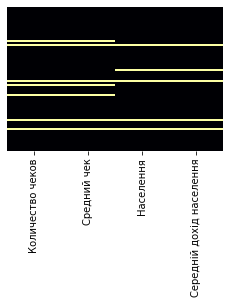

In [85]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 0.5, 0.5])
missings = pd.DataFrame(df.isnull().sum())
vars_with_missings = missings[missings > 1].dropna().index.tolist()
sns.heatmap(df[vars_with_missings].isnull(),
            cbar=False, yticklabels=False, cmap='inferno', ax=ax)
plt.show()

Так как недостающих значений не много можем заменить их средним.

In [86]:
df['Количество чеков'] = df['Количество чеков'].fillna(df['Количество чеков'].mean())
df['Средний чек'] = df['Средний чек'].fillna(df['Средний чек'].mean())
df['Населення'] = df['Населення'].fillna(df['Населення'].mean())
df['Середній дохід населення'] = df['Середній дохід населення'].fillna(df['Середній дохід населення'].mean())
df.isnull().sum()

Успех                        0
Торговельна площа, кв. м.    0
Этаж                         0
Количество касс              0
Тип                          0
Рейтинг в гуглі              0
Количество чеков             0
Средний чек                  0
Населення                    0
Середній дохід населення     0
Спеціалізоване м'ясо         0
Спеціалізований сир          0
Спеціалізована поб. Хімія    0
Супермаркет                  0
Магазин біля дому            0
dtype: int64

Мы можем использовать все данные, пропущенных значений не много.

## Encoding

In [87]:
df.Успех.value_counts()

не успішний    44
успішний       25
Name: Успех, dtype: int64

In [88]:
df.Тип.value_counts()

новий     47
старий    21
cтарий     1
Name: Тип, dtype: int64

In [89]:
type_ = {'новий':0,'старий':1, 'cтарий':1}
df['Тип'] = df['Тип'].map(type_)
df

,Успех,"Торговельна площа, кв. м.",Этаж,Количество касс,Тип,Рейтинг в гуглі,Количество чеков,Средний чек,Населення,Середній дохід населення,Спеціалізоване м'ясо,Спеціалізований сир,Спеціалізована поб. Хімія,Супермаркет,Магазин біля дому
0,не успішний,9.00,1,1,1,3.0,659.0,76.85,108.0,14910.0,1,1,0,1,1
1,не успішний,22.00,1,1,1,4.1,1518.0,84.86,750.0,9030.0,0,0,0,1,1
2,не успішний,13.00,1,1,1,3.0,476.0,112.02,0.0,9030.0,0,0,0,0,0
3,не успішний,18.00,1,1,1,3.0,1310.0,119.80,0.0,13930.0,1,0,0,1,1
4,не успішний,25.00,1,1,0,4.0,2029.0,94.88,0.0,14560.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,успішний,40.78,1,2,0,4.0,6884.0,107.37,963.0,9800.0,0,0,1,0,0
65,успішний,21.50,1,1,0,2.3,4721.0,89.13,0.0,12600.0,1,1,1,0,0
66,не успішний,115.23,1,1,1,3.0,3286.0,105.62,315.0,10570.0,0,0,0,0,1
67,не успішний,34.80,1,2,0,4.3,3963.0,168.07,0.0,12460.0,1,1,0,0,0


In [90]:
type_ = {'не успішний':0,'успішний':1}
df['Успех'] = df['Успех'].map(type_)
df

,Успех,"Торговельна площа, кв. м.",Этаж,Количество касс,Тип,Рейтинг в гуглі,Количество чеков,Средний чек,Населення,Середній дохід населення,Спеціалізоване м'ясо,Спеціалізований сир,Спеціалізована поб. Хімія,Супермаркет,Магазин біля дому
0,0,9.00,1,1,1,3.0,659.0,76.85,108.0,14910.0,1,1,0,1,1
1,0,22.00,1,1,1,4.1,1518.0,84.86,750.0,9030.0,0,0,0,1,1
2,0,13.00,1,1,1,3.0,476.0,112.02,0.0,9030.0,0,0,0,0,0
3,0,18.00,1,1,1,3.0,1310.0,119.80,0.0,13930.0,1,0,0,1,1
4,0,25.00,1,1,0,4.0,2029.0,94.88,0.0,14560.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,1,40.78,1,2,0,4.0,6884.0,107.37,963.0,9800.0,0,0,1,0,0
65,1,21.50,1,1,0,2.3,4721.0,89.13,0.0,12600.0,1,1,1,0,0
66,0,115.23,1,1,1,3.0,3286.0,105.62,315.0,10570.0,0,0,0,0,1
67,0,34.80,1,2,0,4.3,3963.0,168.07,0.0,12460.0,1,1,0,0,0


## Chouse features

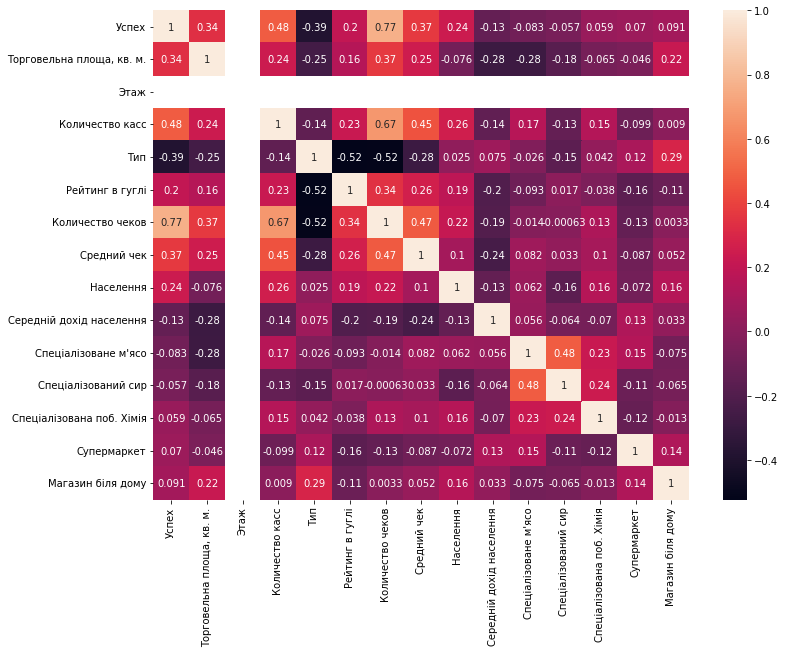

In [91]:
# Cheking correlations
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True)
plt.show()

Самый большой показатель корреляции к парметру "Успех" показывает "Количество чеков" и "Количество касс" остальные же парамте незначительно влияют на знаяения параметра "Успех". Используем эти два параметра для определения успеха.

# Classification Tree & Ensembles

In [92]:
features = ['Количество чеков', 'Количество касс']
X =df[features]
y = df['Успех']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

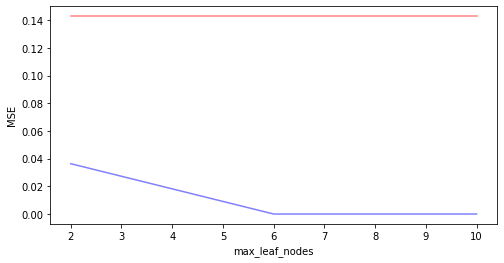

In [93]:
# The optimal number of max_leaf_nodes
max_leaf_nodes(X_train, X_test, y_train, y_test, [2, 4, 6, 8, 10])

## Model

In [94]:
# Fitting Classification Tree to the Training set (2 variables)
ct = DecisionTreeClassifier(max_leaf_nodes = 6, criterion = 'entropy', random_state = 10).fit(X_train, y_train)

## Result

In [95]:
# Predicting the Test set results
y_pred = ct.predict(X_test)
ct.score(X_test,y_test)

0.8571428571428571

In [96]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[9 2]
 [0 3]]


Text(0.5, 1.0, 'Boosting. Feature Importance')

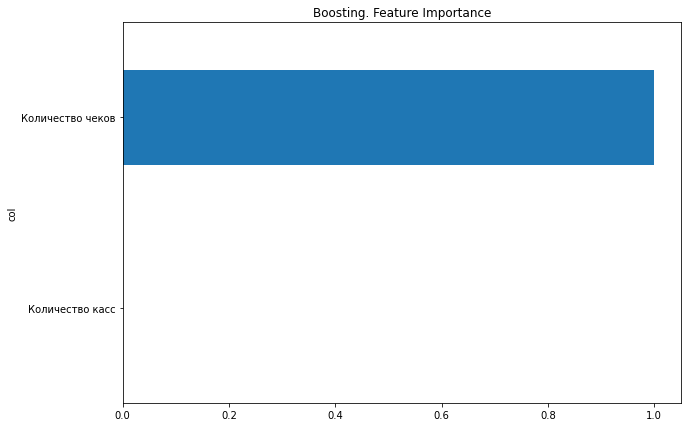

In [97]:
# Features importances
col = features
ct_imp = pd.DataFrame({'imp': ct.feature_importances_, 'col': col})
ct_imp = ct_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-25:]
ct_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance')

## Visualisation

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


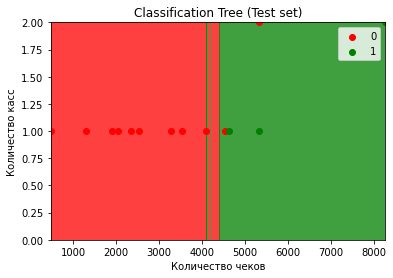

In [98]:
# Visualising the Test set results
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set['Количество чеков'].min() - 1, stop = X_set['Количество чеков'].max() + 1),
                     np.arange(start = X_set['Количество касс'].min() - 1, stop = X_set['Количество касс'].max() + 1))
plt.contourf(X1, X2, ct.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set['Количество чеков'][y_set == j], X_set['Количество касс'][y_set == j],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Classification Tree (Test set)')
plt.xlabel('Количество чеков')
plt.ylabel('Количество касс')
plt.legend()
plt.show()

# Forest


## Paremeters

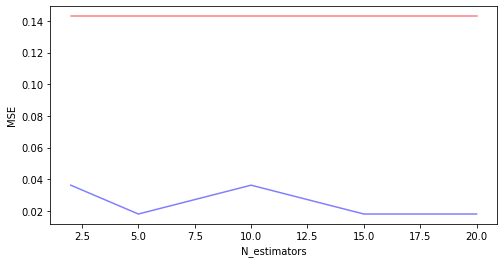

In [99]:
# The optimal number of trees 
rf_best_n_estimator(X_train, X_test, y_train, y_test, [2, 5, 10, 15, 20])

При n_estimators = 5 мы уже можем достичь минимально возможного MSE

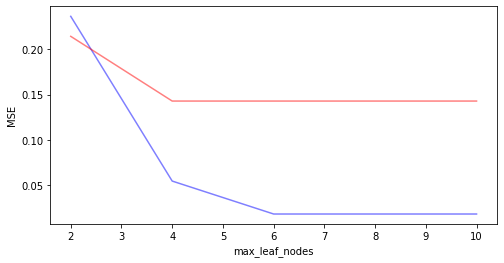

In [100]:
# The optimal number of max_leaf_nodes
rf_max_leaf_nodes(X_train, X_test, y_train, y_test, [2, 4, 6, 8, 10])

При max_leaf_nodes= 4 мы видем что значение MSE на тестовой выборки уже не изменяеться. Возьмем это значение.

## Model

In [101]:
# Fitting Random Forest to the Training set
rf = RandomForestClassifier(n_estimators = 5, max_leaf_nodes = 4, random_state = 10).fit(X_train, y_train)

## Results

In [102]:
# Predicting the Test set results
y_pred = rf.predict(X_test)
y_pred = (y_pred > 0.5)
rf.score(X_test,y_test).round(3)

0.857

In [103]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[9 2]
 [0 3]]


Text(0.5, 1.0, 'Boosting. Feature Importance')

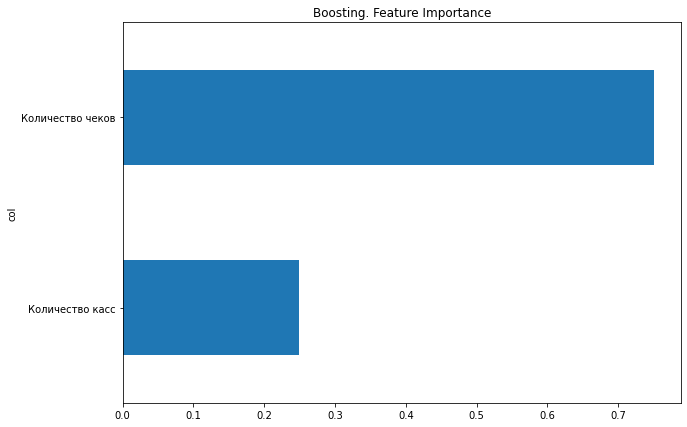

In [113]:
# Features importances
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': col})
rf_imp = rf_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-25:]
rf_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance')

При исползьваниее RandomForestClassifier оба параметра значими. Количество чеков более значимы парметр

# Visualisation

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


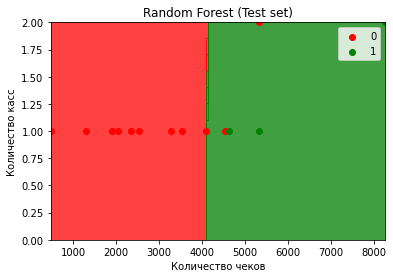

In [105]:
# Visualising the Test set results
X_set, y_set = X_test, y_test
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set['Количество чеков'].min() - 1, stop = X_set['Количество чеков'].max() + 1),
                     np.arange(start = X_set['Количество касс'].min() - 1, stop = X_set['Количество касс'].max() + 1))
plt.contourf(X1, X2, rf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set['Количество чеков'][y_set == j], X_set['Количество касс'][y_set == j],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest (Test set)')
plt.xlabel('Количество чеков')
plt.ylabel('Количество касс')
plt.legend()
plt.show()

# CatBoost

## Paremeters

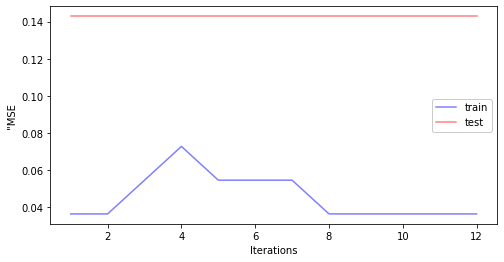

In [106]:
catboost_best_iterations(X_train, X_test, y_train, y_test, list(range(1,13)))

уже при iterations=2 мы достигаем минимальной MSE

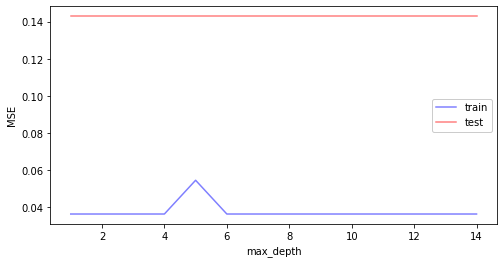

In [107]:
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

при max_depth=2 мы уже получаем минимальное значение MSE

## Model

In [108]:
# Fitting CatBoost to the Training set
cb = CatBoostClassifier(iterations=2,max_depth=2,random_state=10).fit(X_train, y_train,eval_set=(X_test, y_test),logging_level='Silent')

## Results

In [109]:
# Predicting the Test set results
cb_y_pred = cb.predict(X_test)
cb.score(X_test,y_test).round(3)

0.857

In [110]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, cb_y_pred)
print(cm)

[[9 2]
 [0 3]]


Text(0.5, 1.0, 'Boosting. Feature Importance')

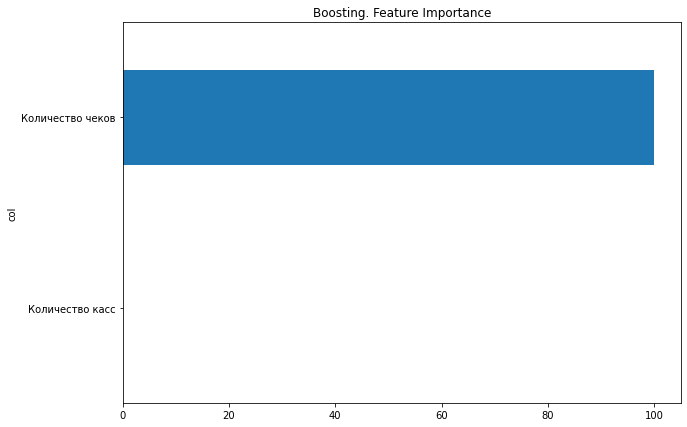

In [111]:
# Features importances
cb_imp = pd.DataFrame({'imp': cb.get_feature_importance(), 'col': col})
cb_imp = cb_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-25:]
cb_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance')

При использовании CatBoostClassifier мы видим что он способен определить класс с той же точность что и RandomForestClassifier используя только "Количество чеков" вторая же пееременная не значима в этой модели

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


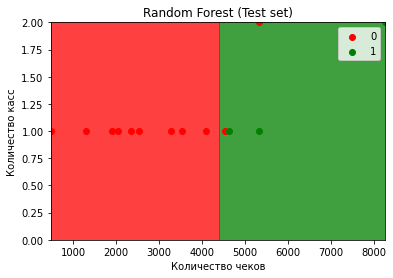

In [112]:
# Visualising the Test set results
X_set, y_set = X_test, y_test
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set['Количество чеков'].min() - 1, stop = X_set['Количество чеков'].max() + 1),
                     np.arange(start = X_set['Количество касс'].min() - 1, stop = X_set['Количество касс'].max() + 1))
plt.contourf(X1, X2, cb.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set['Количество чеков'][y_set == j], X_set['Количество касс'][y_set == j],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest (Test set)')
plt.xlabel('Количество чеков')
plt.ylabel('Количество касс')
plt.legend()
plt.show()

Все подходы классификации показали хороший результат. Точность выше 85% что являеться хорошим показателем. Добавление большего количество переменных может улучшить результат лиш незначительно, так как не имеют высокого показателя корреляции к "Успеху", даже возможено улечшении результатов модели из-за переобучения.

# Hierarchical Clustering

In [117]:
sc = MinMaxScaler().fit(df)
df_arr = sc.transform(df)

In [118]:
df = pd.DataFrame(df_arr, columns=df.columns).round()

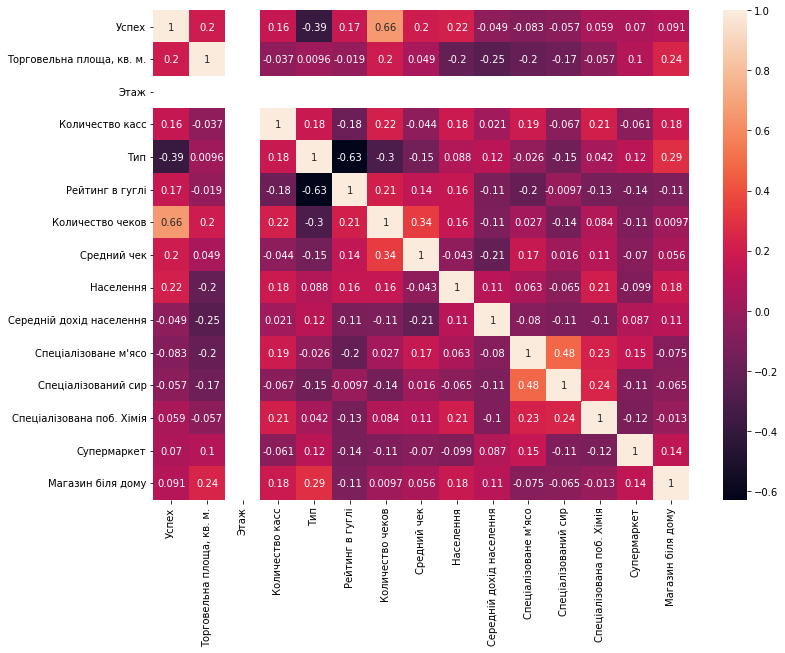

In [119]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True)
plt.show()

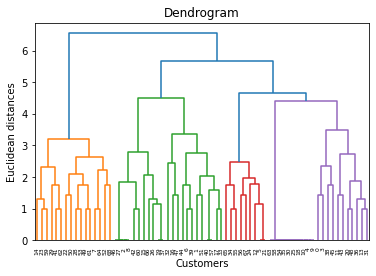

In [120]:
dendrogram = sch.dendrogram(sch.linkage(df, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [121]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward').fit_predict(df)

In [122]:
hc

array([2, 0, 0, 2, 2, 3, 0, 1, 0, 2, 2, 2, 3, 2, 1, 0, 0, 0, 2, 0, 2, 3,
       1, 1, 3, 2, 0, 0, 1, 1, 2, 2, 0, 0, 3, 2, 2, 0, 2, 0, 0, 1, 0, 2,
       0, 2, 0, 0, 2, 1, 1, 0, 1, 1, 2, 3, 3, 0, 2, 1, 0, 1, 1, 2, 1, 3,
       0, 3, 1])

Используя все известные нам данные Иерархическая кластеризация показыват на достаточно четкие 4 класса. Так же можно разбить данные на 6 классов.

# Feature Reduction

Для меня представляет интерес на какие кластеры разделяться данные относительно трех параметров:
- Рейтинг в гуглі
- Количество чеков
- Населення

In [123]:
df.iloc[:, [5, 6, 8]]

,Рейтинг в гуглі,Количество чеков,Населення
0,0.0,0.0,0.0
1,1.0,0.0,1.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
64,1.0,1.0,1.0
65,0.0,0.0,0.0
66,0.0,0.0,0.0
67,1.0,0.0,0.0


In [124]:
X = df.iloc[:, [5, 6, 8]]

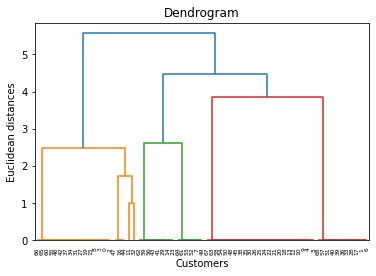

In [125]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

Имеет 3 ярко выраженных кластера

In [126]:
# Fitting Hierarchical Clustering to the dataset
hc_3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward').fit_predict(X)

# K-Means Clustering

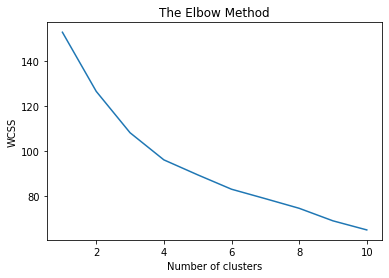

In [127]:
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Видим незначительный перелом в количество классетров 4

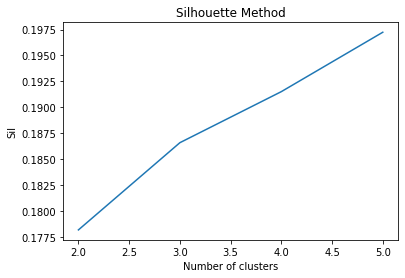

2:0.1781882198249141
3:0.18659499111001565
4:0.1915167949618983
5:0.19724148840642597


In [128]:
# Using the silhouette method to find the optimal number of clusters

sil = []

for k in range(2, 6):
  kmeans = KMeans(n_clusters = k).fit(df)  
  preds = kmeans.fit_predict(df)
  sil.append(silhouette_score(df, preds, metric = 'euclidean'))


plt.plot(range(2, 6), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

for i in range(len(sil)):
 print(str(i+2) +":"+ str(sil[i]))

## Model

In [129]:
# Fitting K-Means to the dataset
km = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0).fit_predict(df)
kms = KMeans(n_clusters = 4, random_state = 0).fit(df)
pd.DataFrame(kms.cluster_centers_, columns = df.columns).round(2)

,Успех,"Торговельна площа, кв. м.",Этаж,Количество касс,Тип,Рейтинг в гуглі,Количество чеков,Средний чек,Населення,Середній дохід населення,Спеціалізоване м'ясо,Спеціалізований сир,Спеціалізована поб. Хімія,Супермаркет,Магазин біля дому
0,0.21,0.04,0.0,-0.00,0.13,0.92,-0.00,-0.00,0.25,1.00,0.08,0.04,0.04,0.25,0.12
1,1.00,0.19,0.0,-0.00,0.00,0.94,0.88,0.31,0.50,0.94,0.19,0.12,0.31,0.12,0.38
2,0.11,0.11,0.0,0.05,1.00,0.16,0.05,0.05,0.32,1.00,0.32,0.16,0.32,0.26,0.58
3,0.20,0.00,0.0,-0.00,-0.00,0.80,0.10,0.20,0.10,0.90,0.90,1.00,0.50,0.10,0.10


## Feature Reduction

Возьмем те же 3 парамета:
- Рейтинг в гуглі
- Количество чеков
- Населення

In [130]:
X = df.iloc[:, [5, 6, 8]]

In [131]:
# Fitting K-Means to the dataset
km_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0).fit_predict(X)
kms_3 = KMeans(n_clusters = 3, random_state = 0).fit(X)
pd.DataFrame(kms_3.cluster_centers_, columns = ['Рейтинг в гуглі','Количество чеков','Населення']).round()

,Рейтинг в гуглі,Количество чеков,Населення
0,0.0,0.0,0.0
1,1.0,0.0,1.0
2,1.0,0.0,-0.0


# Results matching

In [133]:
# Comparing Clustering Algorithms using all features
adjusted_rand_score(hc,km).round(3)

0.47

In [134]:
# Comparing Clustering Algorithms using only 3 features
adjusted_rand_score(hc_3,km_3).round(3)

0.454

Кластеры незначительно схожи при использование двух разных подходов кластеризации. Что при использованиее всех данных что при выборке из 3 параметров

# UMAP + DBSCAN

Для меня представляет интерес как кластеризуються данние при использовании подхода UMAP.
UMAP преобразовует набор данных так что они отражают свою сушьность при этом используя меньшее количество парметров. К примеру мы можем преобразовать 14 праметров об одной компании в 2 которые будут частично отображать в себе все 14. Таким образом подавая на вход в UMAP выборку данных они преобразуються в заданное количество параметров, к примеру в 2 параметра для удобства отображения. 

Я хочу провести кластеризацию на всех данних и посмотреть как они размесятяться на 2д рисунке. При отображении преобразованных данных через UMAP на 2д плоскости, схожие между собой компании будут размешаться рядом. Для того чтобы провести кластеризацию на таких данных лучше всего подойдет DBSCAN. 
Используя "Успех" или "не успех" как label чтобы увидеть схожи ли успешные и не успешные компание между собой. Если схожи мы должны будем увидеть 2 ярковыраженых кластера.

In [11]:
from sklearn.cluster import DBSCAN
import umap

def plot_2d(ar, label_list_cluster, label_list):
    plt.figure(figsize=(10, 7))
    plt.subplots_adjust(bottom=0.1)
    c = label_list_cluster
    plt.scatter(ar[:, 0], ar[:, 1], c=c, cmap='rainbow', label='True Position')

    for label, x, y in zip(label_list, ar[:, 0], ar[:, 1]):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-3, 3),
            textcoords='offset points', ha='right', va='bottom')
    plt.show()

In [12]:
df = pd.read_excel("var4.xlsx", engine='openpyxl')
df.head()

,Успех,"Торговельна площа, кв. м.",Этаж,Количество касс,Тип,Рейтинг в гуглі,Количество чеков,Средний чек,Населення,Середній дохід населення,Спеціалізоване м'ясо,Спеціалізований сир,Спеціалізована поб. Хімія,Супермаркет,Магазин біля дому
0,не успішний,9.0,1,1,старий,3.0,659.0,76.85,108.0,14910.0,1,1,0,1,1
1,не успішний,22.0,1,1,старий,4.1,1518.0,84.86,750.0,9030.0,0,0,0,1,1
2,не успішний,13.0,1,1,старий,3.0,476.0,112.02,0.0,9030.0,0,0,0,0,0
3,не успішний,18.0,1,1,старий,3.0,1310.0,119.80,0.0,13930.0,1,0,0,1,1
4,не успішний,25.0,1,1,новий,4.0,2029.0,94.88,0.0,14560.0,0,0,0,0,0


In [13]:
df['Количество чеков'] = df['Количество чеков'].fillna(df['Количество чеков'].mean())
df['Средний чек'] = df['Средний чек'].fillna(df['Средний чек'].mean())
df['Населення'] = df['Населення'].fillna(df['Населення'].mean())
df['Середній дохід населення'] = df['Середній дохід населення'].fillna(df['Середній дохід населення'].mean())

In [14]:
df_label = df["Успех"]

In [15]:
type_ = {'новий':0,'старий':1, 'cтарий':1}
df['Тип'] = df['Тип'].map(type_)
df

,Успех,"Торговельна площа, кв. м.",Этаж,Количество касс,Тип,Рейтинг в гуглі,Количество чеков,Средний чек,Населення,Середній дохід населення,Спеціалізоване м'ясо,Спеціалізований сир,Спеціалізована поб. Хімія,Супермаркет,Магазин біля дому
0,не успішний,9.00,1,1,1,3.0,659.0,76.85,108.0,14910.0,1,1,0,1,1
1,не успішний,22.00,1,1,1,4.1,1518.0,84.86,750.0,9030.0,0,0,0,1,1
2,не успішний,13.00,1,1,1,3.0,476.0,112.02,0.0,9030.0,0,0,0,0,0
3,не успішний,18.00,1,1,1,3.0,1310.0,119.80,0.0,13930.0,1,0,0,1,1
4,не успішний,25.00,1,1,0,4.0,2029.0,94.88,0.0,14560.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,успішний,40.78,1,2,0,4.0,6884.0,107.37,963.0,9800.0,0,0,1,0,0
65,успішний,21.50,1,1,0,2.3,4721.0,89.13,0.0,12600.0,1,1,1,0,0
66,не успішний,115.23,1,1,1,3.0,3286.0,105.62,315.0,10570.0,0,0,0,0,1
67,не успішний,34.80,1,2,0,4.3,3963.0,168.07,0.0,12460.0,1,1,0,0,0


In [16]:
df = df.drop(columns=['Успех', 'Этаж'])

In [17]:
df_n = (df-df.min())/(df.max()-df.min())
df_n

,"Торговельна площа, кв. м.",Количество касс,Тип,Рейтинг в гуглі,Количество чеков,Средний чек,Населення,Середній дохід населення,Спеціалізоване м'ясо,Спеціалізований сир,Спеціалізована поб. Хімія,Супермаркет,Магазин біля дому
0,0.043365,0.0,1.0,0.37500,0.019868,0.112646,0.112150,0.963801,1.0,1.0,0.0,1.0,1.0
1,0.156114,0.0,1.0,0.71875,0.113126,0.190564,0.778816,0.583710,0.0,0.0,0.0,1.0,1.0
2,0.078057,0.0,1.0,0.37500,0.000000,0.454767,0.000000,0.583710,0.0,0.0,0.0,0.0,0.0
3,0.121422,0.0,1.0,0.37500,0.090544,0.530447,0.000000,0.900452,1.0,0.0,0.0,1.0,1.0
4,0.182134,0.0,0.0,0.68750,0.168603,0.288035,0.000000,0.941176,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.318994,0.5,0.0,0.68750,0.695690,0.409533,1.000000,0.633484,0.0,0.0,1.0,0.0,0.0
65,0.151778,0.0,0.0,0.15625,0.460862,0.232101,0.000000,0.814480,1.0,1.0,1.0,0.0,0.0
66,0.964701,0.0,1.0,0.37500,0.305070,0.392510,0.327103,0.683258,0.0,0.0,0.0,0.0,1.0
67,0.267129,0.5,0.0,0.78125,0.378569,1.000000,0.000000,0.805430,1.0,1.0,0.0,0.0,0.0


[ 0  0  1  0  2  3  4  2  1  2  2  5  3  5  2  0  3  6  2  0  5  3  2  2
  3  2  0  1  4  4  2  5  0  2  3  2  5  0  0  4  1  4  3  5  0  5  1 -1
  1  2  4  0  6  4  2  6  3  1  2  2  1  4  2  2  2  3  0  3  3]


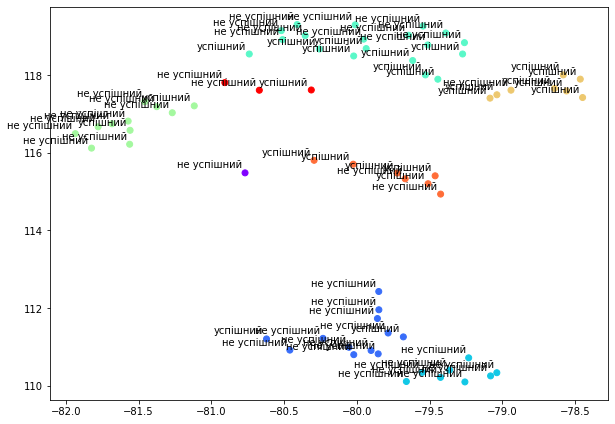

In [18]:
X = df_n.to_numpy()
reducer = umap.UMAP(n_neighbors = 15, min_dist = 0, n_epochs=50000)
X_umap = reducer.fit_transform(X)
clustering = DBSCAN(eps=0.5,min_samples=3).fit(X_umap)
print(clustering.labels_)
plot_2d(X_umap, clustering.labels_, df_label)

Мы получили отличный результат. Есть 2 кластера в котром находяться только успешные компнии и 5 кластеров в которых находяться только не успешные компании. Исходя из этого что есть компании которые добились успеха двумя разными подходами и то что есть 5 различных подгруп не успешных компаний, возможно каждая из этой групп не успешная по своей собственной причини которя одинаковая в этой группе.

Так же есть одна компания которая была отнесена к выбросу. Она не схожа не на одну из тех что есть в данных и она не успешна.